#### **Load and Preprocess Data**

### Create a DataLoader

In [1]:
#Watchdog for any changes in scripts used in the notebook and 
#immediately
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from coco_dataloader import get_loader
from torchvision import transforms

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#define image transform
transform_img = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485,0.456,0.406),
                                                        (0.229,0.224,0.225))])

vocab_threshold = 5
batch_size = 10
coco_dataloader = get_loader(transform=transform_img,
                            mode='train',
                            batch_size=batch_size,
                            threshold=vocab_threshold,
                            load_vocab=False)

loading annotations into memory...
Done (t=1.61s)
creating index...
index created!


KeyboardInterrupt: 


KeyboardInterrupt



##### **Image Pre-Processing**

##### Image pre-processing is straight forward
```
# Convert image to tensor and pre-process using transform
image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
image = self.transform(image)
```
First we load the image from the folder,the transform function used to pre-process the image.The pre-processd PIL image then converted to torch tensor

##### **Caption Pre-Processing**


Our decoder will predict the next token of the caption based on the input image and the all the previous tokens,so initially we tokenize the captions,create a vocabulary space by mapping tokens having occurence greater than threshold to an integer,generate integer captions for each image and caste it to a PyTorch tensor

```
def __init__(self,
                threshold,
                file='./prebuilt_vocab.pkl',
                start_seq='<start>',
                end_seq='<end>',
                unk_word='<unk>',
                anns_file='annotations/captions_train2014.json',
                load_vocab=False):
```

`__init__` method  from the __Vocabulary__ class create the vocab space and  using this instance,`__getitem__ `from __CaptionDataset__ class pre-process the captions

```
# Convert caption to tensor of word ids.
tokens = nltk.tokenize.word_tokenize(str(caption).lower())   # line 1
caption = []                                                 # line 2
caption.append(self.vocab(self.vocab.start_word))            # line 3
caption.extend([self.vocab(token) for token in tokens])      # line 4
caption.append(self.vocab(self.vocab.end_word))              # line 5
caption = torch.Tensor(caption).long()                       # line 6
```

In [9]:
sample_caption = 'A dog is playing with yellow color ball in the park'

In [10]:
#tokenizing caption
import nltk
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'dog', 'is', 'playing', 'with', 'yellow', 'color', 'ball', 'in', 'the', 'park']


In [15]:
modified_caption = list()
start_seq = coco_dataloader.dataset.vocab.start_seq
end_seq = coco_dataloader.dataset.vocab.end_seq

modified_caption.append(start_seq)
modified_caption.extend([token for token in sample_tokens])
modified_caption.append(end_seq)

print(modified_caption)

['<start>', 'a', 'dog', 'is', 'playing', 'with', 'yellow', 'color', 'ball', 'in', 'the', 'park', '<end>']


In [19]:
mapped_caption = [coco_dataloader.dataset.vocab(token) for token in modified_caption]
mapped_caption

[0, 3, 371, 130, 355, 21, 603, 990, 353, 77, 32, 767, 1]

In [20]:
mapped_caption = torch.Tensor(mapped_caption).long()
mapped_caption

tensor([  0,   3, 371, 130, 355,  21, 603, 990, 353,  77,  32, 767,   1])

We take a caption,tokenize it and add special identifiers `<start>` and `<end>` to mark beginning and end of the caption

```
    ['<start>', 'a', 'dog', 'is', 'playing', 'with', 'yellow', 'color', 'ball', 'in', 'the', 'park', '<end>']

```
                                                         

The list of tokens then mapped such that each unique word linked to an integer which is then PyTorch tensor
```
[0, 3, 371, 130, 355, 21, 603, 990, 353, 77, 32, 767, 1]

```
The `__call__` fucntion from __Vocabulary__ class return the integer,if the word in vocabulary space or integer associated with special identifier '<unk>'

In [24]:
# Preview the word2idx dictionary.
print (dict(list(coco_dataloader.dataset.vocab.word2id.items())[:10]))

# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(coco_dataloader.dataset.vocab))

{'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 8856


In [25]:
len(coco_dataloader.dataset.vocab.id2word.keys())

8856

We used threshold to vocabulary count to filter out the less occurence inorder to make the model robust to outliers.Small threshold yields larger tokens

In addition to  identifiers `<start>`,`<end>`,we used  another one `<unk>` to represent the word not belong to the vocabulary space


In [33]:
unk_word = coco_dataloader.dataset.vocab.unk_word
print("Unknown word identifier : {} -> {}".format(unk_word,coco_dataloader.dataset.vocab(unk_word)))

print("For example : {} is mapped to {}".format("Nilakshan",coco_dataloader.dataset.vocab('Nilakshan')))

Unknown word identifier : <unk> -> 2
For example : Nilakshan is mapped to 2


In [6]:
#load vocab from the save pkl file
coco_dataloader = get_loader(transform=transform_img,
                            mode='train',
                            batch_size=batch_size,
#                             threshold=vocab_threshold,
                            load_vocab=True)

Loaded pre-built vocab file
loading annotations into memory...
Done (t=6.52s)
creating index...


  0%|          | 59/414113 [00:00<13:58, 493.69it/s]

index created!


100%|██████████| 414113/414113 [06:36<00:00, 1045.05it/s]


### Generate batches

In [7]:
caption_len = coco_dataloader.dataset.caption_lengths
print("Caption lenght min : {}   max : {}".format(min(caption_len),
                                                     max(caption_len)))

Caption lenght min : 6   max : 57


In [72]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(coco_dataloader.dataset.caption_lengths)

counter_dict = sorted(counter.items(),key=lambda pair:pair[1],reverse=True)

for length,count in counter_dict:
    print("caption_length: {:2d} -> count: {:5d}".format(length,count))


caption_length: 10 -> count: 86332
caption_length: 11 -> count: 79945
caption_length:  9 -> count: 71935
caption_length: 12 -> count: 57639
caption_length: 13 -> count: 37648
caption_length: 14 -> count: 22335
caption_length:  8 -> count: 20769
caption_length: 15 -> count: 12842
caption_length: 16 -> count:  7729
caption_length: 17 -> count:  4842
caption_length: 18 -> count:  3103
caption_length: 19 -> count:  2015
caption_length:  7 -> count:  1597
caption_length: 20 -> count:  1451
caption_length: 21 -> count:   999
caption_length: 22 -> count:   683
caption_length: 23 -> count:   534
caption_length: 24 -> count:   383
caption_length: 25 -> count:   277
caption_length: 26 -> count:   215
caption_length: 27 -> count:   159
caption_length: 28 -> count:   115
caption_length: 29 -> count:    86
caption_length: 30 -> count:    58
caption_length: 31 -> count:    49
caption_length: 32 -> count:    44
caption_length: 34 -> count:    39
caption_length: 37 -> count:    32
caption_length: 33 -

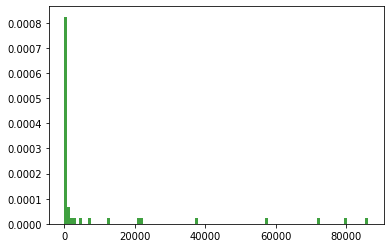

In [66]:
n_bins = 100
x = [v for v in counter.values()]

n, bins, patches = plt.hist(x, n_bins, density=True, facecolor='g', alpha=0.75)


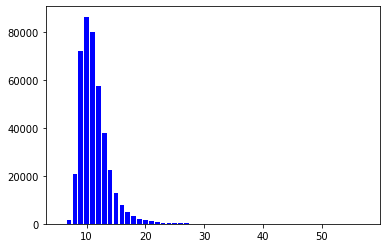

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
lengths = [k for k in counter.keys()]
counts = [v for v in counter.values()]

plt.bar(lengths,counts,color='b')

plt.show()

Generate batch size of  a sampled caption length where the propoability of such caption length proportional to the count of captions in that length.`get_indices` function from __CaptionDataset__ class samples a caption length,then samples `batch_size` indiced associated with training instances of the caption length which is stored in `indices`.
These indices are fed to the dataloader,which is then retrieve the corresponding instances

In [10]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = coco_dataloader.dataset.get_indices()
print('{} sampled indices: {}'.format(len(indices), indices))
# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
coco_dataloader.batch_sampler.sampler = new_sampler

# Obtain the batch.
for batch in coco_dataloader:
    images, captions = batch[0], batch[1]
    break
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

from PIL import Image
c = 0
for img,cap in zip(images,captions):
    plt.figure(c)
    plt.imshow(img.permute(1, 2, 0) )
    c+=1
plt.show()

AttributeError: 'CaptionDataset' object has no attribute 'captionlengths'

In [39]:
#define image transform
transform_img = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485,0.456,0.406),
                                                        (0.229,0.224,0.225))])

vocab_threshold = 5
batch_size = 1
loader = get_loader(transform=transform_img,
                            mode='train',
#                             file='sample.pkl',
                            sample_size=2,
                            batch_size=batch_size,
                            threshold=vocab_threshold,
                            load_vocab=True)

Loaded pre-built vocab file
loading annotations into memory...
Done (t=0.72s)
creating index...


100%|██████████| 2/2 [00:00<00:00, 326.25it/s]

index created!
IDS 414113


In [30]:
type(coco_dataloader.dataset.ids)

list

In [48]:
loader.dataset.batch_size

1

images.shape: torch.Size([1, 3, 224, 224])
captions.shape: torch.Size([1, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


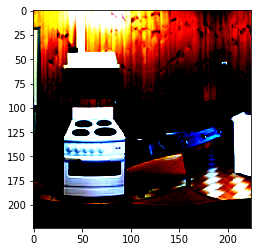

In [41]:
import matplotlib.pyplot as plt
for batch in loader:
    images, captions = batch[0], batch[1]
    
    
    print('images.shape:', images.shape)
    print('captions.shape:', captions.shape)

    from PIL import Image
    c = 0
    for img,cap in zip(images,captions):
        plt.figure(c)
        plt.imshow(img.permute(1, 2, 0) )
        c+=1
    plt.show()